In [16]:
! pip install -q tsai

In [17]:
! pip install -q mplfinance

##Import libraries

In [18]:
import os
from pathlib import Path
import pandas as pd
import sklearn
from tsai.basics import *
from tsai.models import PatchTST
from tsai.metrics import mse, mae
from fastai.callback.tracker import EarlyStoppingCallback
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score, precision_score, mean_absolute_percentage_error, r2_score
import numpy as np
import mplfinance as mpf

### Defin indexes





In [19]:
def compute_rsi(prices, period=14):
    """
    Compute the Relative Strength Index (RSI) for a series of prices.
    Returns a 1D numpy array of RSI values. The first (period-1) values will be NaN.
    """
    prices = np.array(prices)
    deltas = np.diff(prices)
    seed = deltas[:period]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down if down != 0 else 0
    rsi = np.zeros_like(prices)
    rsi[:period] = np.nan
    rsi[period - 1] = 100. - 100. / (1. + rs)
    for i in range(period, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down if down != 0 else 0
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi

def compute_macd(prices, fast=12, slow=26, signal=9):
    """
    Compute the MACD (Moving Average Convergence Divergence) for a series of prices.
    Returns a tuple of three 1D numpy arrays: (macd, signal_line, histogram).
    """
    prices = pd.Series(np.array(prices).flatten())
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd.values, signal_line.values, histogram.values

In [20]:
csv_file_path = '/content/BTC_USD.csv'

# Extract base name without extension for naming
csv_base = Path(csv_file_path).stem

# Define paths for saving the best model and its metrics
model_history_dir = Path('model_history')
result_history_dir = Path('result_history')

os.makedirs(model_history_dir, exist_ok=True)
os.makedirs(result_history_dir, exist_ok=True)

best_model_filename = f"{csv_base}_best_model.pt"
best_model_path = model_history_dir / best_model_filename
metrics_path = result_history_dir / f"{csv_base}_metrics.txt"

forecast_history = 24  # Number of past time steps to use for input sequences.
forecast_horizon = 1  # Number of future time steps to predict (e.g., 0 means predicting the next step immediately).

batch_size = 64  # Number of samples in each mini-batch
max_iterations = 10
model_name = 'PatchTST'

target='price' # or  'rsi'
best_mse = float('inf')
best_metric = float('inf')

###Preprocess

In [21]:
# Load Data
try:
  df_raw = pd.read_csv(csv_file_path)
  print("CSV file loaded successfully.")
except Exception as e:
  print(f"Error reading CSV file: {e}")

df_raw.head(10)

CSV file loaded successfully.


,Date,Price,Open,High,Low,Vol.,Change %
0,01/26/2025,105000.0,104700.0,105440.0,104510.0,0.11K,0.29%
1,01/25/2025,104700.0,104800.0,105260.0,104100.0,0.14K,-0.10%
2,01/24/2025,104800.0,103930.0,107030.0,102720.0,0.52K,0.84%
3,01/23/2025,103930.0,103680.0,106780.0,101260.0,1.70K,0.24%
4,01/22/2025,103680.0,106150.0,106290.0,103400.0,0.51K,-2.33%
5,01/21/2025,106150.0,102170.0,107360.0,100140.0,1.12K,3.90%
6,01/20/2025,102170.0,101360.0,109410.0,99634.0,2.92K,0.80%
7,01/19/2025,101360.0,104490.0,106370.0,99675.0,1.04K,-3.00%
8,01/18/2025,104490.0,104040.0,104950.0,102200.0,0.54K,0.43%
9,01/17/2025,104040.0,100040.0,105800.0,100000.0,1.26K,4.00%


In [22]:
# Preprocess data
datetime_col = "Date"
freq = '1D'
price_col = 'Price'
columns = [price_col]
method = 'ffill'
value = 0


# Define a data preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
            ('shrinker', TSShrinkDataFrame()),
            ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)),
            ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)),
            ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)),
        ], verbose=False)

# Apply the pipeline to the raw data
df = preproc_pipe.fit_transform(df_raw)

# Convert the datetime column to a standard datetime format
df[datetime_col] = pd.to_datetime(df[datetime_col])

# Sort the data by the datetime column in ascending order
df = df.sort_values(by=datetime_col)



Initial memory usage: 201.21 KB 
Final memory usage  : 223.62 KB  (11.1%)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679 entries, 0 to 3678
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3679 non-null   datetime64[ns]
 1   Price     3679 non-null   float32       
 2   Open      3677 non-null   float32       
 3   High      3677 non-null   float32       
 4   Low       3677 non-null   float32       
 5   Vol.      3667 non-null   category      
 6   Change %  3677 non-null   category      
dtypes: category(2), datetime64[ns](1), float32(4)
memory usage: 223.7 KB


In [24]:
# For RSI prediction, add the RSI column
if target == 'rsi':
    df['RSI'] = compute_rsi(df[price_col].values, period=14)

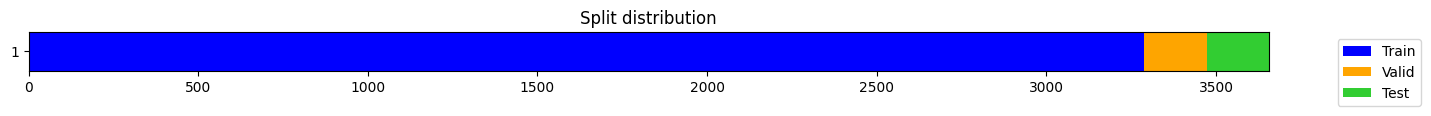

Data splitting into train, validation, and test sets.


In [25]:
# Define the proportions for test and validation sets
test_size = 0.05  # Fraction of the data to be used as the test set
valid_size = 0.05 # Fraction of the data to be used as the validation set

# Define forecasting splits

splits = get_forecasting_splits(
      df,
      fcst_history=forecast_history,
      fcst_horizon=forecast_horizon,
      datetime_col=datetime_col,
      valid_size=valid_size,
      test_size=test_size
  )

# Print the sizes of each split for verification
print("Data splitting into train, validation, and test sets.")


In [26]:
# Create scaling pipeline
# (For both targets, we scale the price column)
scale_columns = [price_col]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=scale_columns)),
              ], verbose=False)

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=splits[0])


# Print a message indicating that the scaling is complete
print("Data scaling completed.")


Data scaling completed.


In [27]:
df_scaled

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-01-01,-0.907131,317.500000,317.500000,312.899994,0.93K,-0.99%
1,2015-01-02,-0.907058,313.600006,316.000000,313.000000,1.32K,0.40%
2,2015-01-03,-0.909095,314.799988,314.799988,282.000000,1.30K,-10.51%
3,2015-01-04,-0.910522,282.000000,288.899994,258.799988,2.38K,-8.23%
4,2015-01-05,-0.909636,261.000000,276.500000,260.500000,2.68K,5.57%
...,...,...,...,...,...,...,...
3674,2025-01-22,5.454093,106150.000000,106290.000000,103400.000000,0.51K,-2.33%
3675,2025-01-23,5.469478,103680.000000,106780.000000,101260.000000,1.70K,0.24%
3676,2025-01-24,5.523018,103930.000000,107030.000000,102720.000000,0.52K,0.84%
3677,2025-01-25,5.516864,104800.000000,105260.000000,104100.000000,0.14K,-0.10%


In [28]:
# Set the features and targets
if target == 'price':
    x_vars = [price_col ]
    y_vars = [price_col]
elif target == 'rsi':
    x_vars = [price_col]
    y_vars = ['RSI']


X, y = prepare_forecasting_data(
            df_scaled,
            fcst_history=forecast_history,
            fcst_horizon=forecast_horizon,
            x_vars=x_vars,
            y_vars=y_vars
        )

###Define model

In [29]:
# Define model architecture configuration
arch_config = dict(
    n_layers=3,
    n_heads=4,
    d_model=16,
    d_ff=128,
    attn_dropout=0.1,
    dropout=0.3,
    patch_len=9,
    stride=2,
    padding_patch=True
)


###Train

In [30]:
def log_print(*args, **kwargs):
    with open(metrics_path, 'a') as metrics_file:
        msg = ' '.join(map(str, args))
        print(msg)
        metrics_file.write(msg + '\n')

In [31]:
# Lists for storing training and validation metrics
train_mse_list = []
val_mse_list = []
final_learn = None  # Keep track of the last iteration's learner

In [35]:
log_print(f"Model Name: {model_name}")
log_print(f"Sequence Length (Forecast History): {forecast_history}")
log_print(f"Forecast Horizon: {forecast_horizon}")
log_print(f"Training Started at: {pd.Timestamp.now()}")
for i in range(max_iterations):
      log_print(f"\nStarting training iteration {i + 1}/{max_iterations}")

      learn = TSForecaster(
          X,y,
          splits=splits,
          batch_size=batch_size,
          path=model_history_dir,
          pipelines=[preproc_pipe, exp_pipe],
          arch=model_name,
          arch_config=arch_config,
          metrics=[mse, mae],
          cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=20)]
      )

      learn.fit_one_cycle(max_iterations, lr_max=0.001)

      # Validate the model
      val_loss = learn.recorder.values[-1][1]
      val_mse = learn.recorder.values[-1][0]
      val_mse_list.append(val_mse)

      train_mse = learn.recorder.values[-1][2] if len(learn.recorder.values[-1]) > 2 else float('nan')
      if not np.isnan(train_mse):
          train_mse_list.append(train_mse)

      scaled_preds_test, *_ = learn.get_X_preds(X[splits[2]])
      scaled_preds_test = to_np(scaled_preds_test).flatten()
      scaled_y_test = y[splits[2]].flatten()

      if target == 'price':
          preds_test = exp_pipe.named_steps['scaler'].inverse_transform(
              pd.DataFrame(scaled_preds_test.reshape(-1, 1), columns=scale_columns)
          ).values.flatten()
          actual_test = exp_pipe.named_steps['scaler'].inverse_transform(
              pd.DataFrame(scaled_y_test.reshape(-1, 1), columns=scale_columns)
          ).values.flatten()
      else:
          preds_test = scaled_preds_test
          actual_test = scaled_y_test

      test_metric = mean_squared_error(actual_test, preds_test)
      log_print(f"Iteration {i + 1}: Test MSE: {test_metric:.4f}, Validation MSE: {val_loss:.4f}")

      if test_metric < best_metric or (test_metric == best_metric and val_loss < best_val_loss):
              best_metric = test_metric
              best_val_loss = val_loss
              log_print(f"Exporting best model to '{best_model_path.resolve()}'")
              learn.export(str(best_model_path.resolve()))
              log_print(f"New best model saved with Test Metric {best_metric:.4f} and Validation MSE {best_val_loss:.4f}")


Model Name: PatchTST
Sequence Length (Forecast History): 24
Forecast Horizon: 1
Training Started at: 2025-05-20 13:45:47.273064

Starting training iteration 1/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.023804,0.055984,0.055984,0.184838,00:03
1,0.013360,0.029780,0.029780,0.132799,00:02
2,0.009430,0.024362,0.024362,0.119208,00:01
3,0.007826,0.021872,0.021872,0.112630,00:01
4,0.006798,0.020776,0.020776,0.108658,00:01
5,0.006273,0.020745,0.020745,0.108450,00:02
6,0.005946,0.020577,0.020577,0.107469,00:02
7,0.005540,0.020183,0.020183,0.106606,00:01
8,0.005701,0.019956,0.019956,0.105978,00:01
9,0.005495,0.019909,0.019909,0.105784,00:01


Iteration 1: Test MSE: 7363096.5000, Validation MSE: 0.0199
Exporting best model to '/content/model_history/BTC_USD_best_model.pt'
New best model saved with Test Metric 7363096.5000 and Validation MSE 0.0199

Starting training iteration 2/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.022260,0.052710,0.052710,0.180735,00:01
1,0.012948,0.022688,0.022688,0.115000,00:01
2,0.008743,0.020683,0.020683,0.108502,00:01
3,0.007381,0.020316,0.020316,0.109431,00:02
4,0.006437,0.019246,0.019246,0.104509,00:01
5,0.005863,0.019237,0.019237,0.104269,00:01
6,0.005759,0.019178,0.019178,0.103854,00:01
7,0.005452,0.018793,0.018793,0.103686,00:01
8,0.005314,0.018619,0.018619,0.102897,00:01
9,0.005303,0.018583,0.018583,0.102831,00:01


Iteration 2: Test MSE: 7325233.0000, Validation MSE: 0.0186
Exporting best model to '/content/model_history/BTC_USD_best_model.pt'
New best model saved with Test Metric 7325233.0000 and Validation MSE 0.0186

Starting training iteration 3/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.023213,0.062373,0.062373,0.195434,00:02
1,0.013456,0.026796,0.026796,0.126472,00:01
2,0.009511,0.022350,0.022350,0.114209,00:01
3,0.007736,0.020741,0.020741,0.109422,00:01
4,0.006743,0.019345,0.019345,0.104126,00:01
5,0.006422,0.019720,0.019720,0.105381,00:01
6,0.005969,0.019382,0.019382,0.103416,00:01
7,0.005778,0.019148,0.019148,0.103083,00:01
8,0.005595,0.019347,0.019347,0.103670,00:02
9,0.005694,0.019254,0.019254,0.103284,00:01


Iteration 3: Test MSE: 7457683.0000, Validation MSE: 0.0193

Starting training iteration 4/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.023897,0.058308,0.058308,0.190786,00:01
1,0.013661,0.031188,0.031188,0.135796,00:01
2,0.009604,0.025971,0.025971,0.124325,00:01
3,0.007682,0.022469,0.022469,0.113732,00:01
4,0.006949,0.021160,0.021160,0.109900,00:01
5,0.006616,0.020497,0.020497,0.107991,00:02
6,0.006275,0.019619,0.019619,0.105981,00:01
7,0.005903,0.020866,0.020866,0.109758,00:01
8,0.005883,0.019624,0.019624,0.105656,00:01
9,0.005880,0.019461,0.019461,0.105253,00:03


Iteration 4: Test MSE: 7374084.0000, Validation MSE: 0.0195

Starting training iteration 5/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.019443,0.053533,0.053533,0.180861,00:02
1,0.011885,0.024748,0.024748,0.121504,00:02
2,0.009022,0.019955,0.019955,0.106597,00:01
3,0.007301,0.017898,0.017898,0.101309,00:01
4,0.006382,0.019094,0.019094,0.104435,00:01
5,0.006009,0.018031,0.018031,0.101124,00:01
6,0.005662,0.018338,0.018338,0.101330,00:01
7,0.005576,0.019038,0.019038,0.103643,00:01
8,0.005516,0.018386,0.018386,0.101371,00:03
9,0.005379,0.018201,0.018201,0.100923,00:01


Iteration 5: Test MSE: 7187741.5000, Validation MSE: 0.0182
Exporting best model to '/content/model_history/BTC_USD_best_model.pt'
New best model saved with Test Metric 7187741.5000 and Validation MSE 0.0182

Starting training iteration 6/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.019826,0.045489,0.045489,0.168204,00:01
1,0.013405,0.029349,0.029349,0.131937,00:01
2,0.009571,0.024393,0.024393,0.118704,00:01
3,0.007808,0.021891,0.021891,0.111441,00:01
4,0.006946,0.022655,0.022655,0.112281,00:01
5,0.006473,0.019834,0.019834,0.104113,00:03
6,0.005959,0.020028,0.020028,0.104891,00:01
7,0.006045,0.019728,0.019728,0.104230,00:01
8,0.006499,0.019652,0.019652,0.103854,00:01
9,0.005906,0.019662,0.019662,0.103915,00:01


Iteration 6: Test MSE: 7250693.0000, Validation MSE: 0.0197

Starting training iteration 7/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.018033,0.048859,0.048859,0.174478,00:01
1,0.011953,0.024103,0.024103,0.117537,00:01
2,0.008590,0.020333,0.020333,0.107525,00:02
3,0.007569,0.020531,0.020531,0.108382,00:01
4,0.006570,0.020464,0.020464,0.107467,00:03
5,0.006078,0.020329,0.020329,0.107178,00:03
6,0.005738,0.019611,0.019611,0.105653,00:03
7,0.005741,0.019598,0.019598,0.105346,00:02
8,0.005492,0.019253,0.019253,0.104471,00:01
9,0.005544,0.019328,0.019328,0.104581,00:01


Iteration 7: Test MSE: 7232468.0000, Validation MSE: 0.0193

Starting training iteration 8/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.015365,0.038926,0.038926,0.153400,00:01
1,0.010206,0.023551,0.023551,0.115816,00:01
2,0.007984,0.020007,0.020007,0.107123,00:01
3,0.006852,0.019540,0.019540,0.105563,00:01
4,0.006456,0.019679,0.019679,0.105165,00:02
5,0.006251,0.019069,0.019069,0.103481,00:01
6,0.005855,0.018942,0.018942,0.102809,00:01
7,0.005620,0.019036,0.019036,0.104138,00:01
8,0.005351,0.019203,0.019203,0.104303,00:01
9,0.005165,0.019075,0.019075,0.104003,00:01


Iteration 8: Test MSE: 7363431.0000, Validation MSE: 0.0191

Starting training iteration 9/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.018185,0.041258,0.041258,0.158470,00:01
1,0.011419,0.028117,0.028117,0.130562,00:02
2,0.009009,0.023152,0.023152,0.117184,00:01
3,0.007724,0.021037,0.021037,0.107528,00:01
4,0.006830,0.020222,0.020222,0.105816,00:01
5,0.006459,0.019790,0.019790,0.104515,00:01
6,0.006083,0.019619,0.019619,0.103772,00:01
7,0.006017,0.019844,0.019844,0.104972,00:01
8,0.005533,0.019900,0.019900,0.105102,00:01
9,0.005742,0.020004,0.020004,0.105431,00:02


Iteration 9: Test MSE: 7538353.5000, Validation MSE: 0.0200

Starting training iteration 10/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.018907,0.050101,0.050101,0.176935,00:01
1,0.011692,0.028800,0.028800,0.129164,00:01
2,0.008714,0.021146,0.021146,0.110277,00:01
3,0.007072,0.019546,0.019546,0.104341,00:01
4,0.006629,0.019978,0.019978,0.105600,00:01
5,0.006083,0.020346,0.020346,0.107504,00:01
6,0.005777,0.019277,0.019277,0.103665,00:02
7,0.005556,0.019555,0.019555,0.104660,00:01
8,0.005730,0.019199,0.019199,0.103094,00:01
9,0.005636,0.019099,0.019099,0.102899,00:01


Iteration 10: Test MSE: 7457641.5000, Validation MSE: 0.0191


In [36]:
# After all iterations, if no best model was exported, export the final iteration's model.
if best_metric == float('inf') and final_learn is not None:
    log_print("No improvement detected across iterations; exporting final iteration model.")
    final_learn.export(str(best_model_path.resolve()))
    # Get predictions and actual values for the test set
    preds_array = to_np(final_learn.get_X_preds(X[splits[2]])[0]).reshape(-1, 1)
    preds_df = pd.DataFrame(preds_array, columns=scale_columns)
    y_array = y[splits[2]].reshape(-1, 1)
    y_df = pd.DataFrame(y_array, columns=scale_columns)
    inv_preds = exp_pipe.named_steps['scaler'].inverse_transform(preds_df)
    inv_y = exp_pipe.named_steps['scaler'].inverse_transform(y_df)
    best_metric = mean_squared_error(inv_y, inv_preds)
    log_print(f"Final model saved with Test Metric {best_metric:.4f}")

# Log summary metrics
if val_mse_list:
    val_mse_mean = np.mean(val_mse_list)
    val_mse_variance = np.var(val_mse_list)
    log_print(f"\nValidation MSE over {max_iterations} iterations: Mean={val_mse_mean:.4f}, Variance={val_mse_variance:.6f}")
else:
    log_print("\nNo Validation MSE recorded.")

if train_mse_list:
    train_mse_mean = np.mean(train_mse_list)
    train_mse_variance = np.var(train_mse_list)
    log_print(f"Training MSE over {max_iterations} iterations: Mean={train_mse_mean:.4f}, Variance={train_mse_variance:.6f}")
else:
    log_print("No Training MSE recorded.")

log_print(f"\nFinal Best Model for '{csv_base}' (Target: {target}) with forecast_history={forecast_history}:")
log_print(f"  Test Metric: {best_metric:.4f}")
log_print(f"  Validation MSE: {best_val_loss:.4f}")
log_print(f"Model saved at: '{best_model_path}'")


Validation MSE over 10 iterations: Mean=0.0056, Variance=0.000000
Training MSE over 10 iterations: Mean=0.0193, Variance=0.000000

Final Best Model for 'BTC_USD' (Target: price) with forecast_history=24:
  Test Metric: 7187741.5000
  Validation MSE: 0.0182
Model saved at: 'model_history/BTC_USD_best_model.pt'


###Evalute

In [37]:
include_baseline  = True

In [38]:
learn = load_learner(str(best_model_path.resolve()))

In [41]:
# After training, evaluate on the test set

scaled_preds_test, *_ = learn.get_X_preds(X[splits[2]])
scaled_preds_test = to_np(scaled_preds_test)
scaled_y_test = y[splits[2]]

if target == 'price':
    preds_test = exp_pipe.inverse_transform(
        pd.DataFrame(scaled_preds_test.reshape(-1, 1), columns=scale_columns)
    )
    actual_test = exp_pipe.inverse_transform(
        pd.DataFrame(scaled_y_test.reshape(-1, 1), columns=scale_columns)
    )
else:
    preds_test = scaled_preds_test
    actual_test = scaled_y_test

test_mse_model = mean_squared_error(actual_test, preds_test)
test_mae_model = mean_absolute_error(actual_test, preds_test)
test_rmse_model = np.sqrt(test_mse_model)
test_r2 = r2_score(actual_test, preds_test)
test_mape = mean_absolute_percentage_error(actual_test, preds_test)

log_print("\nTest Regression Metrics:")
if include_baseline and target == 'price':
    y_baseline_test = exp_pipe.inverse_transform(
        pd.DataFrame(X[splits[2]][:, 0, -1].reshape(-1, 1), columns=scale_columns)
    )
    baseline_mse = mean_squared_error(actual_test, y_baseline_test)
    log_print("Baseline Model:")
    log_print(f"  MAE  : {mean_absolute_error(actual_test, y_baseline_test):.4f}")
    log_print(f"  MSE  : {baseline_mse:.4f}")
    log_print(f"  RMSE : {np.sqrt(baseline_mse):.4f}\n")
log_print(f"{model_name} Model:")
log_print(f"  MAE  : {test_mae_model:.4f}")
log_print(f"  MSE  : {test_mse_model:.4f}")
log_print(f"  RMSE : {test_rmse_model:.4f}")
log_print(f"  R2   : {test_r2:.4f}")
log_print(f"  MAPE : {test_mape:.4f}")



Test Regression Metrics:
Baseline Model:
  MAE  : 1461.9727
  MSE  : 4134576.6503
  RMSE : 2033.3658

PatchTST Model:
  MAE  : 2092.1759
  MSE  : 7187742.1879
  RMSE : 2680.9965
  R2   : 0.9767
  MAPE : 0.0273


In [42]:
mse_val, mae_val, r2_val, mape_val = test_mse_model,test_mae_model,test_r2,test_mape

In [43]:
from google.colab import drive
drive.mount('/content/drive')
try:
  results = pd.read_csv('/content/drive/MyDrive/bitcoin/results.csv')
except Exception as e:
  print(e)
  results = pd.DataFrame(columns=['model','MSE', 'MAE','R2_score','MAPE','time frame', 'type'])

results.loc[len(results)] = [model_name, mse_val, mae_val, r2_val, mape_val, '2015_2025' , 'h']
results.to_csv('/content/drive/MyDrive/bitcoin/results.csv',index=False)
results

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Direction Classification Metrics (Test)
actual_dirs = []
predicted_dirs = []
for i in range(1, len(actuals)):
    actual_dir = 1 if actuals[i] > actuals[i - 1] else 0
    pred_dir = 1 if test_predictions[i] > actuals[i - 1] else 0
    actual_dirs.append(actual_dir)
    predicted_dirs.append(pred_dir)
acc_val = accuracy_score(actual_dirs, predicted_dirs)
prec_val = precision_score(actual_dirs, predicted_dirs, zero_division=0)
rec_val = recall_score(actual_dirs, predicted_dirs, zero_division=0)
f1_val = f1_score(actual_dirs, predicted_dirs, zero_division=0)
log_print("\nTest Direction Classification Metrics:")
log_print(f"  Accuracy : {acc_val:.4f}")
log_print(f"  Precision: {prec_val:.4f}")
log_print(f"  Recall   : {rec_val:.4f}")
log_print(f"  F1       : {f1_val:.4f}")



Test Direction Classification Metrics:
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1       : 1.0000


In [ ]:
if target == 'price':
    previous_prices = exp_pipe.inverse_transform(
        pd.DataFrame(X[splits[2]][:, 0, -1].reshape(-1, 1), columns=scale_columns)
    ).flatten()
    actual_directions = (actual_test > previous_prices).astype(int)
    predicted_directions = (preds_test > previous_prices).astype(int)
    acc = accuracy_score(actual_directions, predicted_directions)
    f1 = f1_score(actual_directions, predicted_directions)
    prec = precision_score(actual_directions, predicted_directions)
    log_print("\nTest Classification Metrics:")
    log_print(f"  Accuracy : {acc:.4f}")
    log_print(f"  F1-Score : {f1:.4f}")
    log_print(f"  Precision: {prec:.4f}")

    # RSI error metrics
    if len(actual_test) >= 14:
        rsi_actual = compute_rsi(actual_test, period=14)
        rsi_pred = compute_rsi(preds_test, period=14)
        valid_idx = ~np.isnan(rsi_actual)
        if valid_idx.sum() > 0:
            rsi_mae = mean_absolute_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
            rsi_mse = mean_squared_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
            log_print(f"\nRSI Metrics:")
            log_print(f"  RSI MAE: {rsi_mae:.4f}")
            log_print(f"  RSI MSE: {rsi_mse:.4f}")
    # MACD error metrics (if enough data)
    if len(actual_test) >= 26:
        macd_actual, _, _ = compute_macd(actual_test)
        macd_pred, _, _ = compute_macd(preds_test)
        macd_mae = mean_absolute_error(macd_actual, macd_pred)
        log_print(f"\nMACD Metric:")
        log_print(f"  MACD MAE: {macd_mae:.4f}")


<Figure size 1400x1000 with 0 Axes>

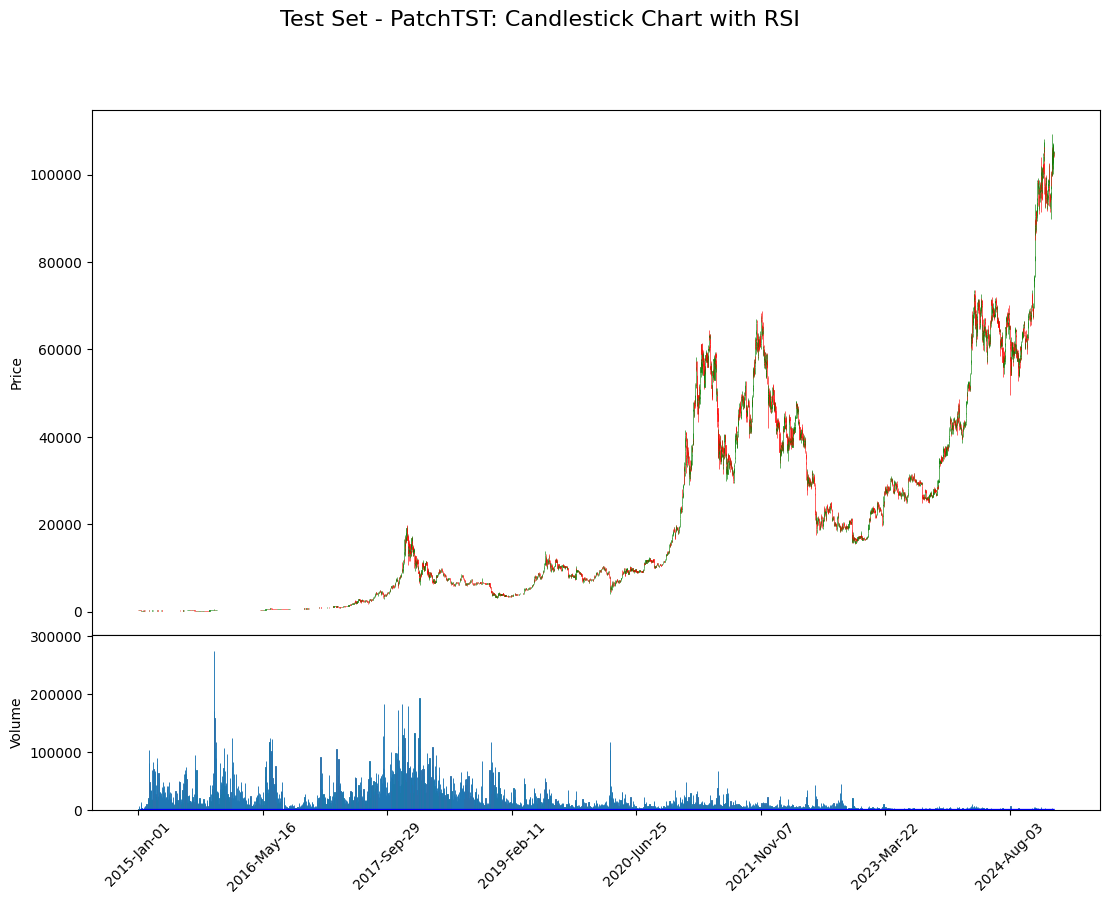

In [ ]:
# Plotting test set predictions: Prices and RSI
indices = np.arange(len(actual_test))
plt.figure(figsize=(14, 10))
if target == 'price':
    plt.subplot(2, 1, 1)
    plt.plot(indices, actual_test, label='Actual Price', marker='o', linestyle='-', color='blue')
    plt.plot(indices, preds_test, label='Predicted Price', marker='x', linestyle='--', color='red')
    if include_baseline:
        plt.plot(indices, y_baseline_test, label='Baseline Prediction', marker='s', linestyle=':', color='green')
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.title(f"Test Set - {model_name}: Actual vs Predicted Prices", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.subplot(2, 1, 2)
    if len(actual_test) >= 14:
        rsi_actual = compute_rsi(actual_test, period=14)
        rsi_pred = compute_rsi(preds_test, period=14)
        plt.plot(indices, rsi_actual, label='Actual RSI', marker='o', linestyle='-', color='blue')
        plt.plot(indices, rsi_pred, label='Predicted RSI', marker='x', linestyle='--', color='red')
        plt.xlabel('Sample Index', fontsize=14)
        plt.ylabel('RSI', fontsize=14)
        plt.title(f"Test Set - {model_name}: RSI Comparison", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Not enough data for RSI calculation', fontsize=14, ha='center')
    plt.tight_layout()
    test_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_plot.png"
    test_plot_path = result_history_dir / test_plot_filename
    plt.savefig(test_plot_path)
    plt.show()
    plt.close()
    log_print(f"Test prediction plot saved to '{test_plot_path}'")

# Create candlestick chart with RSI for the test period (using full data)
df_candle = df_raw.copy()
df_candle[datetime_col] = pd.to_datetime(df_candle[datetime_col])
df_candle = df_candle.sort_values(by=datetime_col)
if 'Price' in df_candle.columns:
    df_candle.rename(columns={'Price': 'Close'}, inplace=True)
# Check if volume data exists in your DataFrame. If the column is named "Vol.", rename it to "Volume"
if 'Vol.' in df_candle.columns:
    df_candle.rename(columns={'Vol.': 'Volume'}, inplace=True)
    df_candle['Volume'] = df_candle['Volume'].apply(lambda x: float(x.replace('K',''))*1000 if isinstance(x, str) and 'K' in x else float(x))
df_candle.set_index(datetime_col, inplace=True)
rsi_values = compute_rsi(df_candle['Close'].values, period=14)
df_candle['RSI'] = rsi_values
apds = [mpf.make_addplot(df_candle['RSI'], panel=1, color='blue', ylabel='RSI')]
mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
s  = mpf.make_mpf_style(marketcolors=mc)
# Plot volume if available; otherwise, volume=False
volume_flag = True if 'Volume' in df_candle.columns else False
fig, axlist = mpf.plot(df_candle, type='candle', style=s, volume=volume_flag,
                        addplot=apds, returnfig=True, figsize=(14,10), panel_ratios=(3,1))
fig.suptitle(f"Test Set - {model_name}: Candlestick Chart with RSI", fontsize=16)
candle_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_candlestick.png"
candle_plot_path = result_history_dir / candle_plot_filename
fig.savefig(candle_plot_path)
plt.show()
plt.close(fig)